## Initial Exploration

In [1]:
# Lets import our necessary libraries
import pandas as pd
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import plot_importance

In [27]:
# Create our list of dataframes containing each dataset
df = pd.read_csv('../Data/dataset83.csv')

In [28]:
# Remove unecessary data
df.drop(['Year_start', 'Year_end'], axis='columns', inplace=True)

In [29]:
# Visualise each dataset
sns.pairplot(df)

In [ ]:
# Encode Categorical Data into numerical format
label_encoder = LabelEncoder()

for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        # Fill missing values with mean for numerical columns
        col_mean = df[col].mean()
        df[col] = df[col].fillna(col_mean)
    elif df[col].dtype == 'object':
        # Fill missing values with mode for categorical columns
        col_mode = df[col].mode()[0]
        df[col] = df[col].fillna(col_mode)


Best Estimator: Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.8617036394461618,
                               colsample_bynode=0.6021607936800394,
                               colsample_bytree=0.8614612668927372, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=6.938446453918847,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.16456367256344734, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=16,
                               max_leaves=None, min_child_weight=None,
                          

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

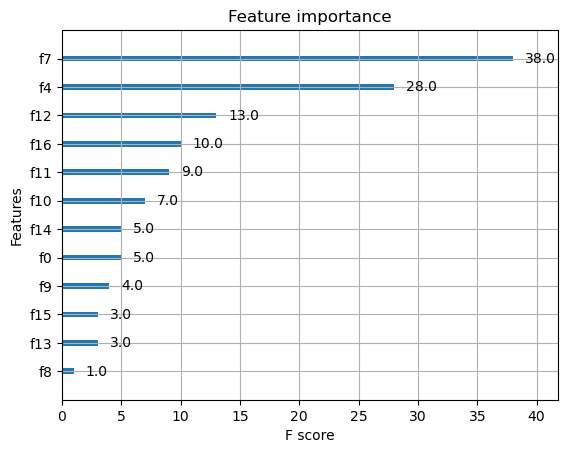

In [ ]:
# now our data is in a format fit for a model, we need to decide what model and what we want the model to be able to do, maybe first we should see if it can guess teh species and population based on the other data
# Split up features and label
X = df.drop(columns='wing_loading')
y = df['wing_loading']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform a 80/20 train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, stratify=y, random_state=420)

# Setup the estimators with the xgb classifier
estimators = [
    ('clf', XGBRegressor(random_state=420, n_estimators=300))
]

# Create pipeline
pipe = Pipeline(steps=estimators)

# Setup tuning for the hyperparameters 
search_space = {
    'clf__max_depth': Integer(2, 17),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}
opt = BayesSearchCV(pipe, search_space, cv=10, n_iter=10, scoring='roc_auc', random_state=420)
opt.fit(X_train, y_train)
print(f"Best Estimator: {opt.best_estimator_}\n")
print(f"Best Score: {opt.best_score_}\n")
print(f"Test Score: {opt.score(X_test, y_test)}\n")
print(f"Predictions: {opt.predict(X_test)}\n")
print(f"Probabilities: {opt.predict_proba(X_test)}\n")
print(f"Steps: {opt.best_estimator_.steps}\n")

# Plot importance of each of the features in the final classification
xgboost_step = opt.best_estimator_.steps[0]
xgboost_model = xgboost_step[1]
print(xgboost_model)
plot_importance(xgboost_model)


